# Richardson-Lucy Algorithm - Week 3

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2
from skimage import data, color, restoration
import torch
import torch.nn.functional as F


### Use of a prebuilt RL function from the skimage library:

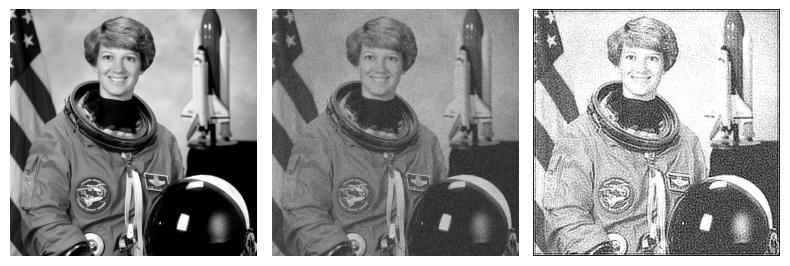

In [56]:
rng = np.random.default_rng()
image = color.rgb2gray(data.astronaut())
image_noisy = image + (rng.poisson(lam=25, size=image.shape)-10) / 50
deconvoluted_image = restoration.richardson_lucy(image_noisy, np.ones((5, 5)) / 25, num_iter=20)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(image_noisy, cmap='gray')
ax[1].axis('off')
ax[2].imshow(deconvoluted_image, cmap='gray')
ax[2].axis('off')
fig.tight_layout()
plt.show()

Overexposes the image and does little to reduce noise.

### Attempt at producing my own from scratch algoithm for RL:

In [81]:
def gaussian_kernel_2d(size, sigma=1.0):
    ax = torch.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / kernel.sum()

def gaussian_normalised_kernel_1D(size=21, sigma=2.0):
    ax = torch.linspace(-(size // 2), size // 2, size)
    kernel = torch.exp(-0.5 * (ax / sigma) ** 2)
    kernel = kernel / torch.sum(kernel)  # Normalize the kernel
    return kernel


def poisson_noise(image, scale_factor=1000):
    photon_counts = image * scale_factor
    noisy_photons = torch.poisson(photon_counts)
    noisy_image = noisy_photons / scale_factor
    return torch.clamp(noisy_image, 0, 1)

def convo1d(image, kernel):
    # Ensure image is 3D: [batch, channel, length]
    if image.dim() == 1:
        image = image.unsqueeze(0).unsqueeze(0)  # [L] -> [1, 1, L]
    elif image.dim() == 2:
        image = image.unsqueeze(0)  # [C, L] -> [1, C, L]
    
    # Ensure kernel is 3D: [out_channels, in_channels, kernel_length]
    if kernel.dim() == 1:
        kernel = kernel.unsqueeze(0).unsqueeze(0)  # [L] -> [1, 1, L]
    elif kernel.dim() == 2:
        kernel = kernel.unsqueeze(0)  # [C, L] -> [1, C, L]
    
    padding = (kernel.shape[-1] - 1) // 2
    result = torch.nn.functional.conv1d(image, kernel, padding=padding)
    
    # Return as 1D if input was 1D
    return result.squeeze()

def convo2d(image, kernel):
    if image.dim() == 2:
        image = image.unsqueeze(0).unsqueeze(0)  # [H, W] -> [1, 1, H, W]
    elif image.dim() == 3:
        image = image.unsqueeze(0)  # [C, H, W] -> [1, C, H, W]
    
    if kernel.dim() == 2:
        kernel = kernel.unsqueeze(0).unsqueeze(0)  # [H, W] -> [1, 1, H, W]
    elif kernel.dim() == 3:
        kernel = kernel.unsqueeze(0)  # [C, H, W] -> [1, C, H, W]
    
    # Calculate padding for 'same' convolution
    padding = ((kernel.shape[-2] - 1) // 2, (kernel.shape[-1] - 1) // 2)
    
    filtered = F.conv2d(image, kernel, stride=1, padding=padding)
    
    # Remove added dimensions
    return filtered.squeeze(0).squeeze(0)

def richardson_lucy(degr_image, kernel, num_its, estimate=None, c = 1e-10):
    if estimate is None:
        estimate = torch.ones_like(degr_image)
    else:
        estimate = estimate.clone()
    

    if len(kernel.shape) == 1:
        kernel_mirror = torch.flip(kernel, [0])
        conv_func = convo1d
    elif len(kernel.shape) == 2:
        kernel_mirror = torch.flip(kernel, [-1, 0])
        conv_func = convo2d
    else:
        raise ValueError("Kernel must be 1D or 2D tensor")

    for _ in range(num_its):
        # Convolve estimate with kernel
        blurred_estimate = conv_func(estimate, kernel)
        # Avoid division by zero
        blurred_estimate = torch.clamp(blurred_estimate, min=c)
        # Calculate ratio
        ratio = degr_image / blurred_estimate
        # Convolve ratio with mirrored kernel and update estimate
        estimate = estimate * conv_func(ratio, kernel_mirror)
        # Optional: clamp to prevent negative values
        estimate = torch.clamp(estimate, min=0)

    return estimate 


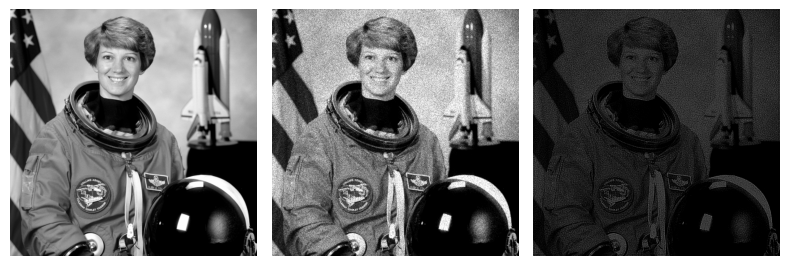

In [82]:

image_tensor = torch.tensor(image, dtype=torch.float32)
image_noisy = poisson_noise(image_tensor, scale_factor=50)

kernel = gaussian_kernel_2d(5, sigma=1.0)
deconvoluted_image_custom = richardson_lucy(image_noisy, kernel, num_its=30)

#deconvoluted_image_custom = richardson_lucy(image_noisy, torch.ones((5, 5, 5, 5)) / 25, num_its=5)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(image_noisy, cmap='gray')
ax[1].axis('off')
ax[2].imshow(deconvoluted_image_custom, cmap='gray')
ax[2].axis('off')
fig.tight_layout()
plt.show()


Under exposes the image and little loss of noise, underexposure worsens with increased iterations.

Now will test on a 1D signal.

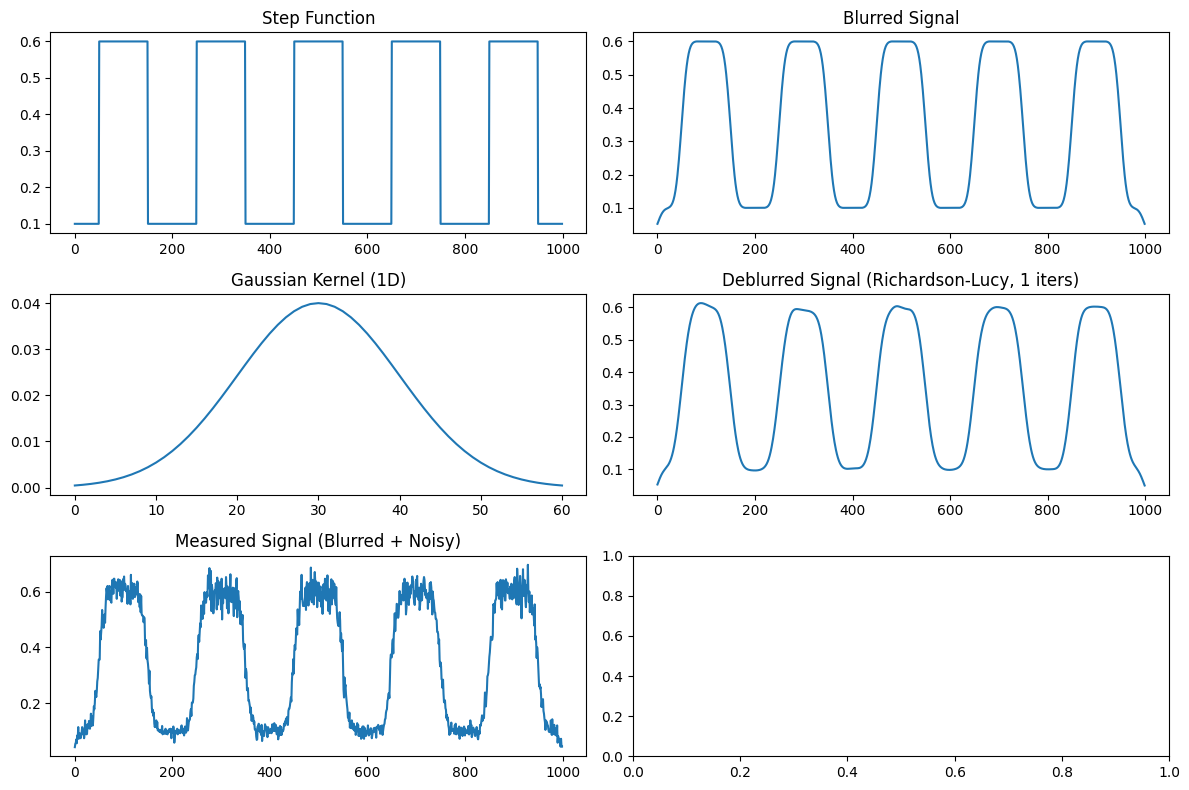

In [89]:
def step_function(period=2.0):
    xs = torch.linspace(-5, 5, steps=1000)
    ys = (((xs.round() % period) == 0).float() + 0.2)/2
    return xs, ys

num_iters = 1

x, y = step_function()
signal = y.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
kernel = gaussian_normalised_kernel_1D(size = 61, sigma = 10.0)

blurred_signal = convo1d(signal, kernel)
measured_signal = poisson_noise(blurred_signal, scale_factor=500)

deblurred_signal = richardson_lucy(measured_signal, kernel, num_its=num_iters)

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs[0, 0].plot(y)
axs[0, 0].set_title('Step Function')
axs[1, 0].plot(kernel.squeeze())
axs[1, 0].set_title('Gaussian Kernel (1D)')
axs[2, 0].plot(measured_signal.squeeze())
axs[2, 0].set_title('Measured Signal (Blurred + Noisy)')
axs[0, 1].plot(blurred_signal.squeeze())
axs[0, 1].set_title('Blurred Signal')
axs[1, 1].plot(deblurred_signal.squeeze())
axs[1, 1].set_title(f'Deblurred Signal (Richardson-Lucy, {num_iters} iters)')
plt.tight_layout()

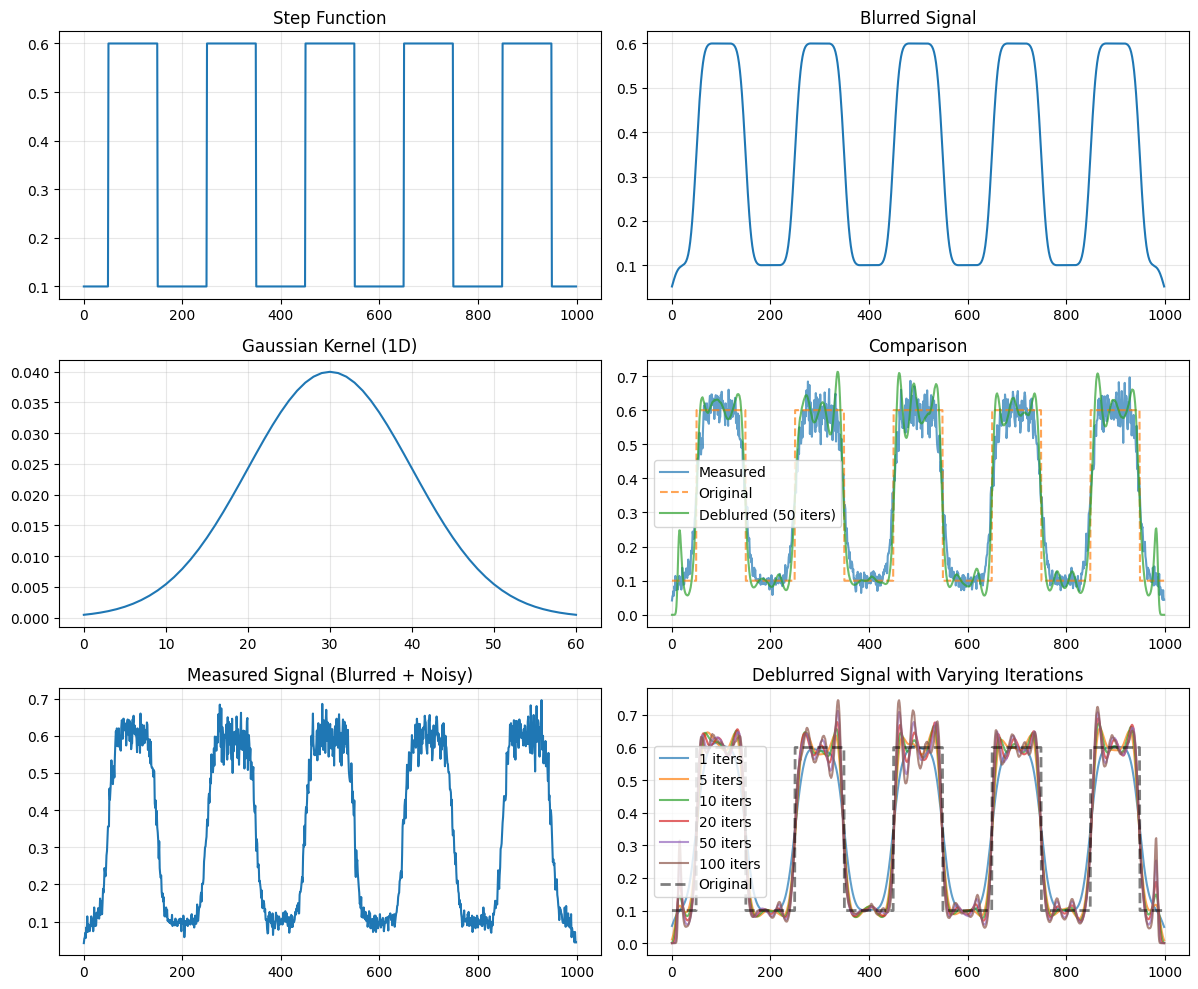

In [93]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Plot original and preprocessing
axs[0, 0].plot(y)
axs[0, 0].set_title('Step Function')
axs[0, 0].grid(True, alpha=0.3)

axs[1, 0].plot(kernel)
axs[1, 0].set_title('Gaussian Kernel (1D)')
axs[1, 0].grid(True, alpha=0.3)

axs[2, 0].plot(measured_signal)
axs[2, 0].set_title('Measured Signal (Blurred + Noisy)')
axs[2, 0].grid(True, alpha=0.3)

axs[0, 1].plot(blurred_signal)
axs[0, 1].set_title('Blurred Signal')
axs[0, 1].grid(True, alpha=0.3)

# Plot comparison at fixed iterations
axs[1, 1].plot(measured_signal, label='Measured', alpha=0.7)
axs[1, 1].plot(y, label='Original', alpha=0.7, linestyle='--')
deblurred_fixed = richardson_lucy(measured_signal, kernel, num_its=50)
axs[1, 1].plot(deblurred_fixed, label='Deblurred (50 iters)', alpha=0.7)
axs[1, 1].set_title('Comparison')
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

# Plot varying iterations
num_iters = [1, 5, 10, 20, 50, 100]
for i in num_iters:
    deblurred_signal = richardson_lucy(measured_signal, kernel, num_its=i)
    axs[2, 1].plot(deblurred_signal.squeeze(), label=f'{i} iters', alpha=0.7)
    
axs[2, 1].plot(y, 'k--', label='Original', linewidth=2, alpha=0.5)
axs[2, 1].set_title('Deblurred Signal with Varying Iterations')
axs[2, 1].legend(loc='best')
axs[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()  # Make sure this is called

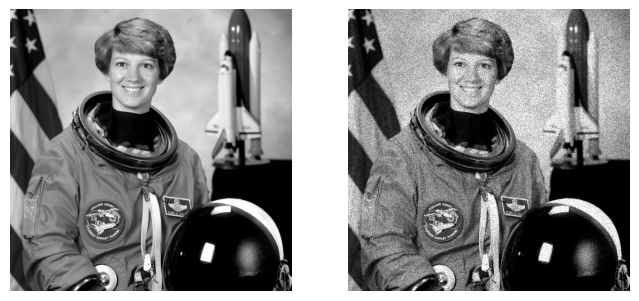

In [ ]:

#testing poisson noise function
image_tensor = torch.tensor(image, dtype=torch.float32)
noisy_image_tensor = poisson_noise(image_tensor, scale_factor=50)
noisy_image_np = noisy_image_tensor.numpy()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(noisy_image_np, cmap='gray')
ax[1].axis('off')
plt.show()